In [1]:
import tensorflow as tf
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


# print(tf.__version__)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [8]:
def plot_series(time, series, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None, forward=1, mode='train'):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    if mode == 'train':
        dataset = dataset.window(window_size + forward, shift=forward, drop_remainder=True)
    else:
        dataset = dataset.window(window_size, shift=forward, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forward))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-forward], window[-forward]))

    # Shuffle the windows
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

def series_splitter(series, test_ratio=0.2):
    total = len(series)
    train_size = int(total - (total * test_ratio))
    train_data = series[:train_size]
    test_data = series[train_size:]
    return train_size, train_data, test_data

In [20]:
# Parameters
WINDOW_SIZE = 20
BATCH_SIZE = 16
BUFFER_SIZE = 1000
EPOCHS = 250
PATIENCE = 5
MONITOR = 'val_loss'
SPLIT_RATIO = 0.2

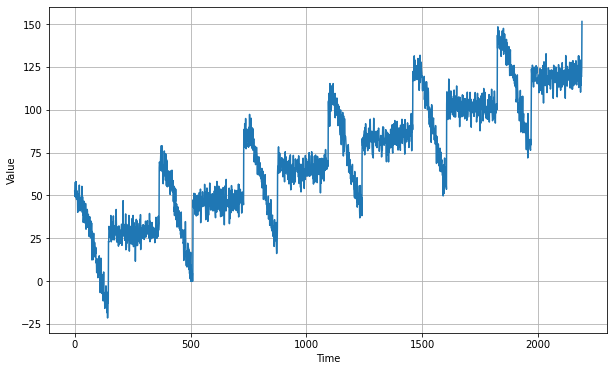

In [15]:
# Parameters
time = np.arange(6 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

(1752,) (439,) (1752,) (439,)


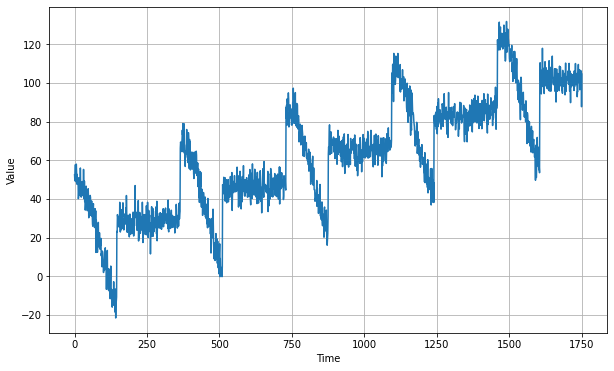

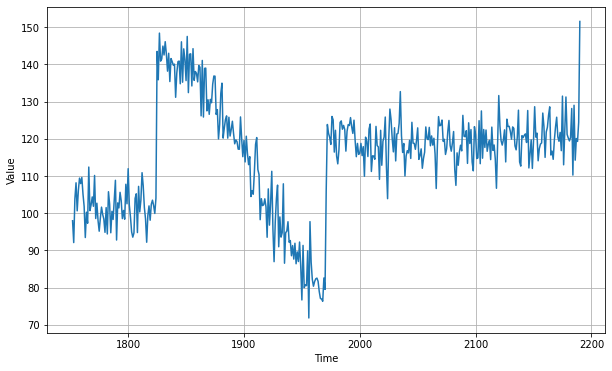

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))> <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
shape of feature: (16, 20)
shape of label: (16,)


In [16]:
# Get the train set 
_, time_train, time_valid = series_splitter(time, SPLIT_RATIO)
split_time, x_train, x_valid = series_splitter(series, SPLIT_RATIO)
print(time_train.shape, time_valid.shape, x_train.shape, x_valid.shape)

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

# Generate the dataset windows
train_dataset = windowed_dataset(
    x_train, 
    WINDOW_SIZE, 
    BATCH_SIZE, 
    shuffle_buffer=BUFFER_SIZE,
)
test_dataset = windowed_dataset(
    x_valid, 
    WINDOW_SIZE, 
    BATCH_SIZE, 
    shuffle_buffer=BUFFER_SIZE,
)

print(train_dataset, test_dataset)

# Print shapes of feature and label
for window in train_dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

In [18]:
MODEL_NAME = './models/TimeSeries_LSTM_GRU_full_verse.h5'
tf.keras.backend.clear_session()
callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))]
# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-7)]
# callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
# callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=int(PATIENCE**1.5 if PATIENCE > 5 else PATIENCE**2), restore_best_weights=True)]

# Build the Model
model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE])
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="tanh", input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Setup the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['mae', 'mse']#, tf.keras.losses.Huber(), tf.keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
print(model.summary())

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

Minimum achived loss was: 77
Best Learning Rate is: 7.079458e-05


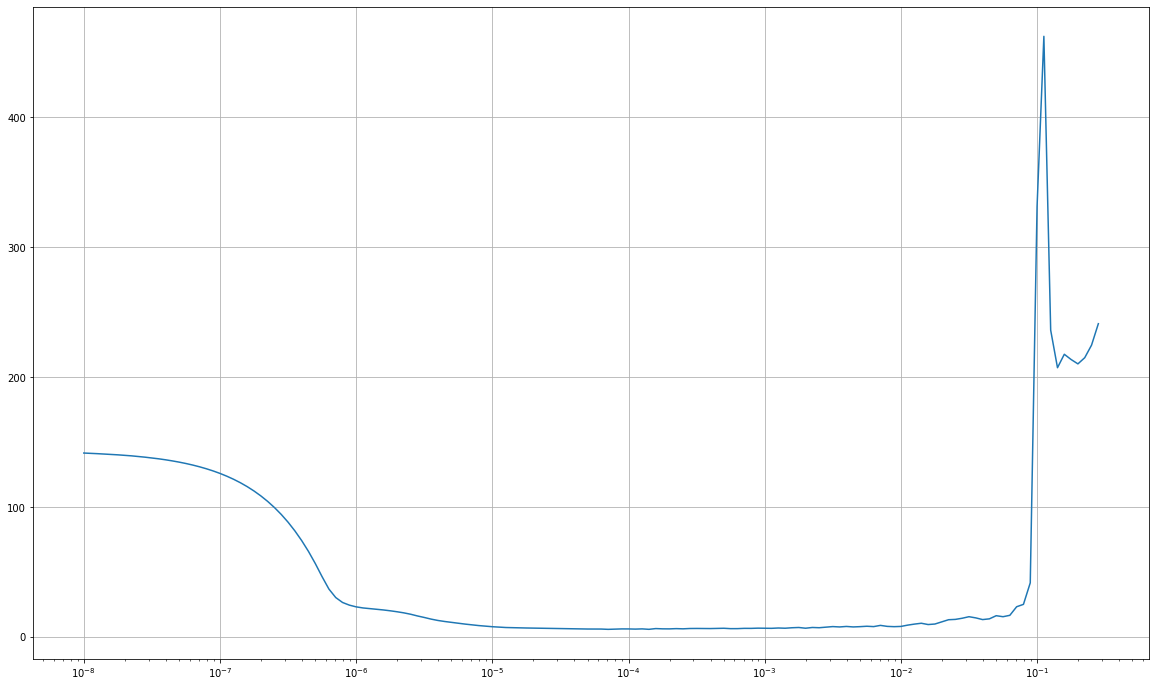

In [19]:
# Set the figure size
plt.figure(figsize=(20, 12))
# Set the grid
plt.grid(True)

print('Minimum achived loss was:', np.argmin(history.history['loss']))
print('Best Learning Rate is:', history.history['lr'][np.argmin(history.history['loss'])])
# Plot the loss in log scale
plt.semilogx(history.history['lr'], history.history["loss"])

In [27]:
MODEL_NAME = './models/TimeSeries_CNN_RNN_full_verse.h5'
tf.keras.backend.clear_session()

class ThrisholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        '''
        Halts the training when a certain metric is met

        Args:
          epoch (integer) - index of epoch (required but unused in the function definition below)
          logs (dict) - metric results from the training epoch
        '''

        # Check the validation set MAE
        if(logs.get('val_mae') < 5.2):
            
            # Stop if threshold is met
            print("\nRequired val MAE is met so cancelling training!")
            self.model.stop_training = True
            
# callbacks = [tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))]
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-7)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=int(PATIENCE**1.5 if PATIENCE > 5 else PATIENCE**2), restore_best_weights=True)]
callbacks += [ThrisholdCallback()]

# Build the Model
model = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE])
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400.0)
])

# Setup the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Nadam(7e-5),
    metrics=['mae', 'mse']#, tf.keras.losses.Huber(), tf.keras.metrics.RootMeanSquaredError()]
)

# Print the model summary
print(model.summary())

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-traina

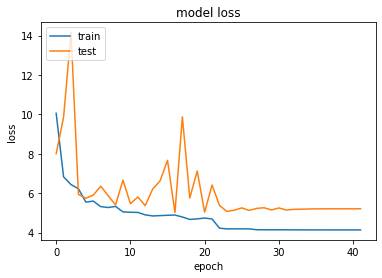

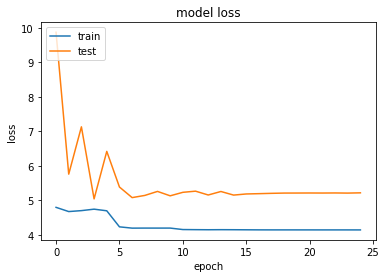

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][-25:])
plt.plot(history.history['val_loss'][-25:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

110/110 [==============================] - 1s 5ms/step
196.63649
8.794627


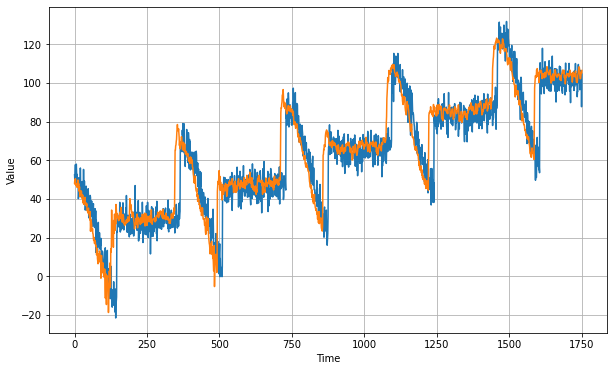

In [29]:
forecast_dataset = windowed_dataset(series[1:split_time + WINDOW_SIZE], WINDOW_SIZE, BATCH_SIZE, mode='pred')

results = model.predict(forecast_dataset).squeeze()

# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_train, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_train, results).numpy())

# Plot the results
# plot_series(time_valid, (x_valid, results))
plot_series(time_train, (x_train, results))

28/28 [==============================] - 0s 10ms/step
67.367584
5.7811856


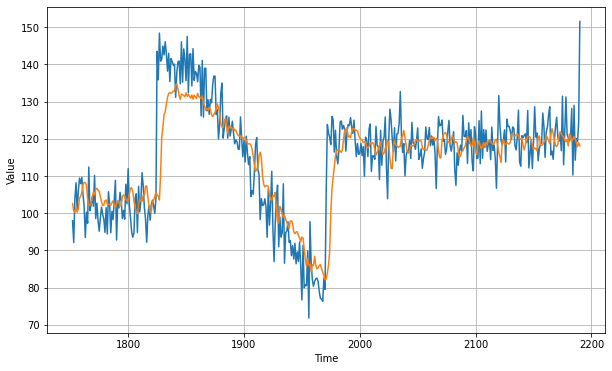

In [30]:
# Reduce the original series
forecast_series = series[split_time - WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast_dataset = windowed_dataset(forecast_series, WINDOW_SIZE, BATCH_SIZE, mode='pred')
results = model.predict(forecast_dataset).squeeze()


# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Plot the results
plot_series(time_valid, (x_valid, results))